# **Audio Signal Processing for Music Applications** -Εxam 2021

#**Part 1**

Google Drive setup, installations, importing dependencies


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install python-dev ipython python-numpy python-matplotlib python-scipy cython

In [3]:
% cd'/content/drive/MyDrive/sms-tools'
#! git clone https://github.com/MTG/freesound-python.git
#! git pull

/content/drive/MyDrive/sms-tools


In [4]:
#% cd'/content/drive/MyDrive/sms-tools/freesound-python'
#! python setup.py install

In [8]:
% cd'/content/drive/MyDrive/sms-tools/'
import os, sys
import json
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
sys.path.append('../../freesound-python/')  
import freesound as fs
import IPython.display as ipd

/content/drive/MyDrive/sms-tools


**Introduce sound file and reproduce.**

In [9]:

initial_file="./sounds/413203__joepayne__clean-and-pompous-fanfare-trumpet_mono.wav"
fs, full = UF.wavread(initial_file) #read sound as numpy array and extract sampling rate (fs)
#------------segmentation -----  #
y=full[int(np.floor(0.228*44100)):int(np.ceil(2.833*44100))]  #transforming seconds to samples by N=Δt*fs and selecting only the meaningful parts of the track. 
#Silence parts are only contributing with background noise. 
UF.wavwrite(y,fs, './sounds/joepayne__clean-and-pompous-fanfare-trumpet_processed.wav')  #save new sound file

/content/drive/MyDrive/sms-tools/software/models/utilFunctions.py:52: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = read(filename)


In [10]:
#Play sound
sound_file='./sounds/joepayne__clean-and-pompous-fanfare-trumpet_processed.wav'
fs, trumpet = UF.wavread(sound_file)
ipd.display(ipd.Audio(data=trumpet, rate=fs))


**STFT magnitude spectrogram**

Text(0.5, 1.0, 'STFT Magnitude Spectrogram')

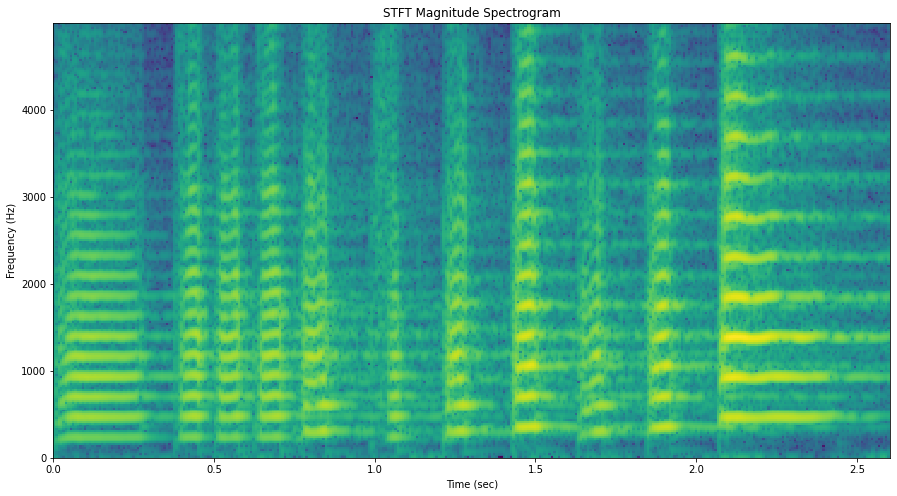

In [11]:
#framing parameters
M = 1323 
N = int(pow(2, np.ceil(np.log2(M))))
window = 'blackman'
w = get_window(window, M, fftbins=True)
H = M//4


#STFT Analysis-Synthesis
mX, pX = STFT.stftAnal(trumpet, w, N, H)

#Plot
max_frequency=5000
frames = H*np.arange(mX.shape[0])/float(fs)                             
bins = float(fs)*np.arange(N*max_frequency/float(fs))/N


plt.figure(figsize=(15, 8))
plt.pcolormesh(frames, bins, np.transpose(mX[:,:int(np.ceil(N*max_frequency/float(fs)))]))
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT Magnitude Spectrogram')



As we observed on a more "superficial" level, by listening to the sound excerpt, we are faced with a typical breathy trumpet sound, consisted of short (in duration) sinusoidals, with rich harmonic content, that form a melodic line. In the corresponding spectrogram we can clearly see the distinct fundamental frequencies along with their numerous harmonics, as yellow-ish lines of high-intensity, that show an ascending tendency through time.

The lowest fundamental frequency is observed during the first $0.5 sec$, and appears to around $\approx 125-250 Hz $. With that in mind, we can perform a better STFT analysis using a **larger window**, in order to capture sinusoidals with biggest period, by taking advantage of the formula :    
$$ B_s \cdot \frac{f_s}{125Hz}=6\cdot \frac{44100Hz}{125Hz}\approx 2117 samples$$ 
That way we increase the frequency resolution while loosing only a bit of the time-resolution. It should be mentioned thoughh that after a window size of $5001 samples$ for example we get a fuzzy image, with clear lines bin-wise, while none of the transitions nor any temporal information are preserved. Similar motivation (frequency resolution) lead us to choose a Blackman window that has a pretty good signal-to-noise ratio, with a main-lobe good enough for frequency dinstiction (Blackman-Harris would bring better SNR, however it has a larger main-lobe).

Our perception of the **rich harmonic content** can be verified by the Dft Analysis spectrum below, where we are able to recognise many harmonics up to **almost** $8kH$. Of course, exactly due to the particular "ascending" melodic line of the trumpet, as the harmonics are climbing higher, they contain less energy and thus we end up with this resulting **descending** magnitute Dft spectrum.
In case we are interested to perform a *harmonic* or an *HPS/-R analysis*, we can always consider an initial "*guess*" of $\frac{(44100Hz)/2}{150Hz}\approx 147$ harmonics. (In that case,according to the STFT, we should also consider an f0 estimation range of $100$ to $600Hz$.In order to distinguish the instrument's melody from its stochastic noise components, we would have to exclude harmonics higher than $8kHz$).

Last (but not least), is important to mention what we already suspected given the spectrogram and  is now pretty obvious in the undermentioned time representation plot:  we are not dealing with a typical long-sustained trumpet notes, but in contrast there are brief-decayed events with **clear attacks**.That could play an important role when it comes to recognition/classification (+onset-beat detection etc.).

Text(0.5, 1.0, 'signal in time domain')

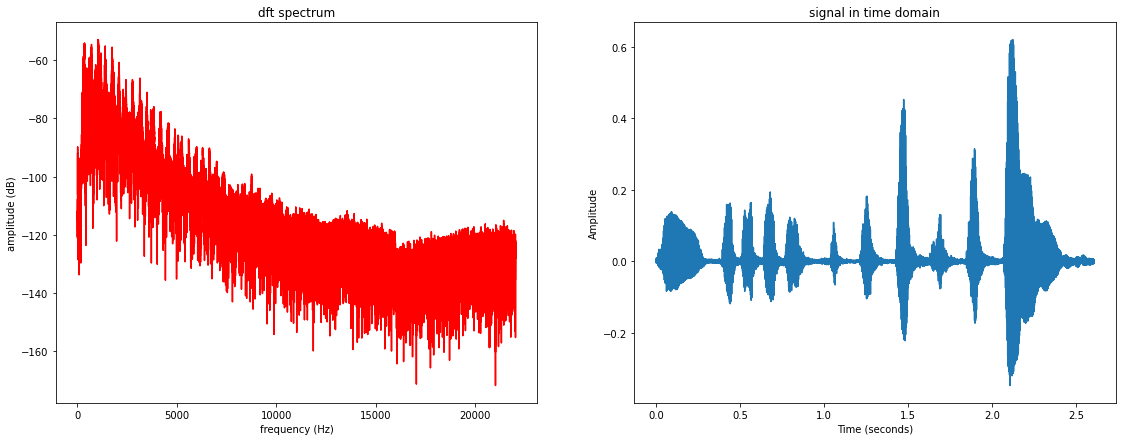

In [12]:
#DFT prep
from dftModel import dftAnal
length= len(trumpet)
w2 = get_window('blackman', length)
N2 = int(pow(2, np.ceil(np.log2(length))))
X, phX = dftAnal(trumpet,w2,N2)
freq_axis=np.arange(X.shape[0])*(fs/N2)


#Amplitude envelope prep

time=np.arange(0,len(trumpet), 1)/44100




#Plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(19,7))
ax1.plot(freq_axis,X, 'r')

ax1.set_xlabel('frequency (Hz)')
ax1.set_ylabel('amplitude (dB)')

ax2.plot(time, trumpet)

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude')
ax1.set_title('dft spectrum')
ax2.set_title('signal in time domain')





# **Part 2 (option c)**

## **Analyzing sound - Sound Descriptors**
[All descriptors will be represented by their mean values even if not stated explicitly]

In [ ]:
import freesound as fs
#%pip install essentia     --uncomment to install essentia library
import essentia.standard as es
from essentia.standard import *


In [15]:
#feature extraction for trumpet sound with Essentia


data_feats={} #initialize dictionary of features for trumpet sound


features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'])('./sounds/joepayne__clean-and-pompous-fanfare-trumpet_processed.wav')
print("Filename:", features['metadata.tags.file_name'])
print("-"*80)

mfccs=features['lowlevel.mfcc.mean']
print("MFCC mean:",mfccs )

#saving
for i,mfcc in enumerate(mfccs):
  data_feats['mfcc'+str(i)]=mfccs[i]

print("-"*80)
spectral_centroid=features['lowlevel.spectral_centroid.mean']
print('Spectral Centroid (mean):', spectral_centroid)
data_feats['spectral_centroid']=spectral_centroid #saving


spectral_flux=features['lowlevel.spectral_flux.mean']
print('Spectral Flux (mean):', spectral_flux)
data_feats['spectral_flux']=spectral_flux #saving

spectral_rolloff=features['lowlevel.spectral_rolloff.mean']
print('Spectral Roll-Off (mean):', spectral_rolloff)
data_feats['spectral_rolloff']=spectral_rolloff #saving


hfc=features['lowlevel.hfc.mean']
print('HFC (mean):', hfc)
data_feats['hfc']=hfc #saving




Filename: joepayne__clean-and-pompous-fanfare-trumpet_processed.wav
--------------------------------------------------------------------------------
MFCC mean: [-8.92825134e+02  1.41057358e+02 -1.05163925e+02 -4.34293327e+01
 -2.81344795e+01 -2.21508369e+01 -1.64991302e+01 -1.72109966e+01
 -2.21572266e+01 -1.22039356e+01 -3.33984208e+00 -1.26079953e+00
  7.91024745e-01]
--------------------------------------------------------------------------------
Spectral Centroid (mean): 1182.3504638671875
Spectral Flux (mean): 0.03806659206748009
Spectral Roll-Off (mean): 1502.2242431640625
HFC (mean): 11.670111656188965


In [16]:
data_feats

{'hfc': 11.670111656188965,
 'mfcc0': -892.82513,
 'mfcc1': 141.05736,
 'mfcc10': -3.339842,
 'mfcc11': -1.2607995,
 'mfcc12': 0.79102474,
 'mfcc2': -105.163925,
 'mfcc3': -43.429333,
 'mfcc4': -28.13448,
 'mfcc5': -22.150837,
 'mfcc6': -16.49913,
 'mfcc7': -17.210997,
 'mfcc8': -22.157227,
 'mfcc9': -12.203936,
 'spectral_centroid': 1182.3504638671875,
 'spectral_flux': 0.03806659206748009,
 'spectral_rolloff': 1502.2242431640625}

## **Obtain descriptors for all 3 different classes, using Freesound API**

[All descriptors will be represented by their mean values even if not directly stated]

In [17]:
#Freesound Client
Key="G1eSNBtlubi9E4X3oRFts7KPrBWuoESZUSUgcsQt"
freesound_client = fs.FreesoundClient()
freesound_client.set_token(Key)

Picking sounds 

In [18]:
#classes containing hand-picked audio tracks' ID's

classes={
    "Wind-Brass" : [749,759,748,256217,1236, 354722,255174,354682,356958, 121027 ],
    "Strings" : [ 495954, 23110,23112,23113, 2604,121018, 179933, 195138,13721, 255834  ],
    "Percussion":[89608,90453, 47831, 455646, 18428, 610355,429539, 167385, 413802,40381]
}


The main idea here was to create 3 main categories that would share a lot in common (same instrument "family" ), but would not contain exactly the same instruments and more importantly they could not describe the same instrument as the one we're working on. We carefuly hand-picked our sounds for the 3 classes so that they all are consisted of a brief *melody* (or *phrase* in case of percussion) without any prominent sustained components. That way, we approached the problem in a more **fair** way (for example huge differentiations in onsets would lead to a trivial classification problem, with not much of feature engineering work needed). For similar reasons, during the mining process for the "percussion" class, we didn´t just choose random percussive instruments or drums, but we were looking for the most harmonic ones (*bongos,conga,african djembe*) that can form a kind of a melodic line as well. "Strings" class is consisted mainly of *violin*, *cello* and *viola* sounds, while the "Wind-Brass" category includes two types of wind instruments, the *woodwind* ones (*clarinet*, *flute*, *bassoon*) and the *brass-labrophones* (*saxophone*). Trumpet is left out intentionally and the whole class is mixed with instruments that belong to the most generic category of wind instruments, in hopes of capturing the main timbre profile using spectral descriptors.

Load descriptors for all sounds and save in **json** file

In [19]:
data={}


feats=['spectral_centroid','spectral_flux','spectral_rolloff','hfc']

for key in classes:
  for id in classes[key]:
    sound = freesound_client.get_sound(
    id,
    fields="name,analysis",
    descriptors="lowlevel.mfcc.mean,lowlevel.spectral_centroid.mean,lowlevel.spectral_flux.mean,lowlevel.spectral_rolloff.mean,lowlevel.hfc.mean")







    temp_dict=sound.analysis.lowlevel.mfcc.as_dict()
    data[id]={}
    for i,value in enumerate(temp_dict['mean']):
      if i<6:
        data[id]['mfcc'+str(i)]=value
    
    for f in feats:
      data[id][f]=eval("sound.analysis.lowlevel."+f+'.mean')
    
    data[id]['class']=key

      
#write to json file  
with open("all_features.json", "w") as outfile:
    json.dump(data, outfile)
    




## **KNN Classification Algorithm**

In [20]:
import pandas as pd

In [21]:

tmp = pd.read_json("all_features.json")
df=tmp.T
df.head() #example of first 5 sounds in class "Wind-Brass"


,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,spectral_centroid,spectral_flux,spectral_rolloff,hfc,class
749,-753.062,28.6359,-110.556,-11.8391,-9.90365,0.879004,1894.12,0.140809,2668.28,283.897,Wind-Brass
759,-740.588,50.1422,-89.6003,24.5115,-10.1073,-1.72876,1536.91,0.0690448,2576.12,134.393,Wind-Brass
748,-764.155,85.6687,-105.084,-11.3632,-25.7664,-10.4849,1559.86,0.0652551,2579.12,62.4054,Wind-Brass
256217,-847.106,90.4858,-33.5857,0.518598,-16.3945,-25.025,2478.41,0.0611951,3484.75,29.2595,Wind-Brass
1236,-779.34,37.4351,-81.1082,-15.8865,-37.8516,-33.6758,1329.39,0.0701729,2150.37,43.9776,Wind-Brass


Encoding class names

In [22]:
df['class']= pd.Categorical(df['class'])  #convert "class" column to type "Categorical"
cat_columns = df.select_dtypes(['category']).columns  #select only Categorical columns ("class" column)
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes) #replace with encoding {0,1,2}={"Wind-Brass", "Strings", "Percussion"}
df #show the whole dataframe

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,spectral_centroid,spectral_flux,spectral_rolloff,hfc,class
749,-753.062,28.6359,-110.556,-11.8391,-9.90365,0.879004,1894.12,0.140809,2668.28,283.897,2
759,-740.588,50.1422,-89.6003,24.5115,-10.1073,-1.72876,1536.91,0.0690448,2576.12,134.393,2
748,-764.155,85.6687,-105.084,-11.3632,-25.7664,-10.4849,1559.86,0.0652551,2579.12,62.4054,2
256217,-847.106,90.4858,-33.5857,0.518598,-16.3945,-25.025,2478.41,0.0611951,3484.75,29.2595,2
1236,-779.34,37.4351,-81.1082,-15.8865,-37.8516,-33.6758,1329.39,0.0701729,2150.37,43.9776,2
354722,-884.127,54.0449,-99.976,-39.4772,-27.8438,-12.72,969.26,0.0212326,1417.26,20.1013,2
255174,-974.308,132.842,16.309,-20.0476,-18.136,-6.56005,365.973,0.0243618,458.103,8.68121,2
354682,-891.498,76.2921,-104.655,-41.6832,-26.0449,-17.0446,891.08,0.018143,1228.11,17.0831,2
356958,-937.107,121.225,-47.5176,-24.3135,1.1691,8.28208,498.174,0.0185789,822.612,6.4662,2
121027,-716.612,33.9681,-156.317,5.48337,-33.5259,-30.6977,1267.7,0.119215,2154.39,499.677,2


In [90]:
#KNN 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

y = df['class']
X =df.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)





KNeighborsClassifier()

In [91]:
from sklearn.metrics import accuracy_score
pred = knn.predict(X_test)
accuracy_score(pred,y_test)

0.5

In [92]:
series = pd.Series(data_feats)
df_ev=pd.DataFrame(series).transpose()
df_ev=df_ev.drop(['mfcc{}'.format(i) for i in range(6,13)], axis=1)
df_ev #show evaluation sound features -- our trumpet sound

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,spectral_centroid,spectral_flux,spectral_rolloff,hfc
0,-892.825134,141.057358,-105.163925,-43.429333,-28.13448,-22.150837,1182.350464,0.038067,1502.224243,11.670112


In [93]:
prediction= knn.predict(df_ev)
prediction #predicted 0 : Wind-Brass!!! 

array([0], dtype=int8)